In [1]:
import torch
import torchvision.datasets
import torchvision.transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
n_epochs = 4
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [3]:

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('imgs/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(2),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('imgs/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(2),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

for data, label in train_loader:
  print(data.shape)
  break


100.0%
100.0%
100.0%
100.0%


torch.Size([64, 1, 32, 32])


In [ ]:
class CryptoNet(nn.Module):
    def __init__(self):
        super(CryptoNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(2560, 10, bias =  False)
        self.fc2 = nn.Linear(10, 10, bias = False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu (x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

        
network = CryptoNet()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

network.eval()
lossfn = nn.CrossEntropyLoss()

In [5]:


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    output = network(data)
    loss = lossfn(output, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
      
      
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += lossfn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

network.eval()

with torch.no_grad():
  torch.save(network.state_dict(), 'model.pth')


Test set: Avg. loss: 0.0362, Accuracy: 1101/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303207
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.114858
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.888515
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.863096
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.789468
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.771693
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.733170
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.689638
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.668500
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.656852
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.643129
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.662391
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.604640
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.636922
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.598889
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.578400
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.589834
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.591621
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.577902
Train Epoch: 1 [12160

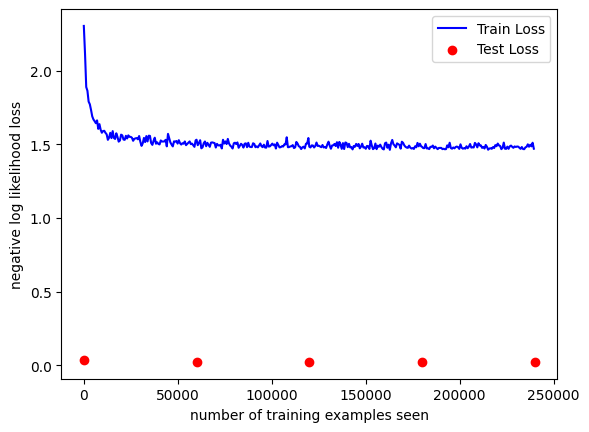

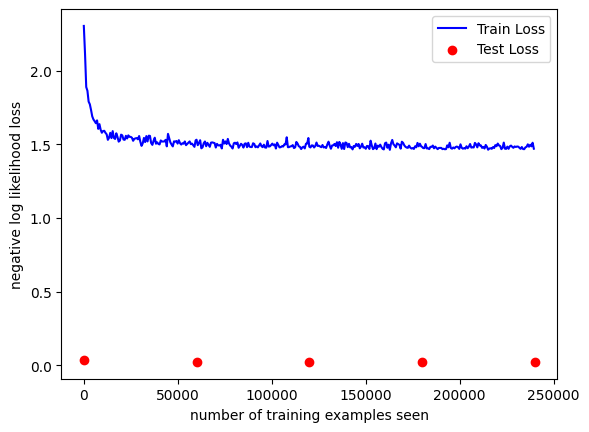

In [8]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig